# Project - Twitter US Airline Sentiment

## Import the libraries, load dataset, the print shape of data, data description. 

In [67]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob, Word
import enchant
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
#!python -m spacy download en
#!pip install textblob
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#!pip install PyEnchant
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\talk2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
ench=enchant.Dict("en_US")

In [6]:
df = pd.read_csv("Tweets.csv")

In [49]:
df_bak=pd.read_csv("Tweets.csv")

In [7]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
df.shape

(14640, 15)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Understand of data columns: 

### a. Drop all other columns except “text” and “airline_sentiment”.

In [11]:
columns_to_drop=["tweet_id","airline_sentiment_confidence","negativereason","negativereason_confidence","airline","name",
                "airline_sentiment_gold","negativereason_gold","retweet_count","tweet_coord","tweet_created","tweet_location","user_timezone"]
df.drop(columns=columns_to_drop,inplace=True)

 ### b. Check the shape of the data.

In [12]:
df.shape

(14640, 2)

### c. Print the first 5 rows of data

In [13]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


***

## 3. Text pre-processing: Data preparation. 
### NOTE:- Each text pre-processing step should be mentioned in the notebook separately.
     a. Html tag removal.
     b. Tokenization.
     c. Remove the numbers.
     d. Removal of Special Characters and Punctuations.
     e. Removal of stopwords
     f. Conversion to lowercase.
     g. Lemmatize or stemming.
     h. Join the words in the list to convert back to text string in the data frame. (So that each row
          contains the data in text format.)
     i. Print the first 5 rows of data after pre-processing.

In [14]:
def pre_processing( raw ):
    # Function to convert a raw  to a string of words
    # The input is a single string (a raw tweet, and 
    # the output is a single string (a preprocessed tweet)
    #
    # a. Remove HTML
    review_text = BeautifulSoup(raw).get_text() 
    # b. Tokenization.
    tokenized_words=word_tokenize(review_text)
    nonstop_words=[]
   
    for word in tokenized_words:
        #
        # c. Remove the numbers.
        # d. Removal of Special Characters and Punctuations.
        if word.isalpha():
            # f. Conversion to lowercase.
            lower_words = word.lower()   

            #
            # e. Removal of stopwords
            stops = set(stopwords.words("english"))  
            
            #check if its a 'non' stop word and a valid word in english dictionary
            if lower_words not in stops and ench.check(lower_words)==True:
                nonstop_words.append(lower_words)
            
            sent_without_stop=" ".join( nonstop_words )
            #
            # g. Lemmatize or stemming.
            doc = nlp(sent_without_stop)
            tokens = []
            for token in doc:
                tokens.append(token)
            
            lemmatized_sentence = " ".join([token.lemma_ for token in doc])
    # h.Join the words in the list to convert back to text string in the data frame. (So that each row
    #      contains the data in text format.)
    return( "".join(lemmatized_sentence ))  

## i. Print the first 5 rows of data after pre-processing.

In [15]:
for i in range(5):
    processed_tweet=pre_processing(df.iloc[i]["text"])
    print(processed_tweet)

say
plus add commercial experience tacky
today must mean need take another trip
really aggressive blast obnoxious entertainment guest face little recourse
really big bad thing


In [16]:
%%time
num_reviews = df["text"].size
clean_tweets = []
# Loop over each tweet; create an index i that goes from 0 to the length
# of the movie review list 
for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_tweets.append( pre_processing( df["text"][i] ) )

Wall time: 19min 13s


In [17]:
df["clean_text"]=pd.DataFrame(clean_tweets)

In [18]:
df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [19]:

le = preprocessing.LabelEncoder()
y=le.fit_transform(df["airline_sentiment"])

---

# EDA

In [50]:
df_bak["airline_sentiment_num"]=y

In [52]:
df_bak.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,airline_sentiment_num
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0


Text(0.5, 0.98, 'Characters in message')

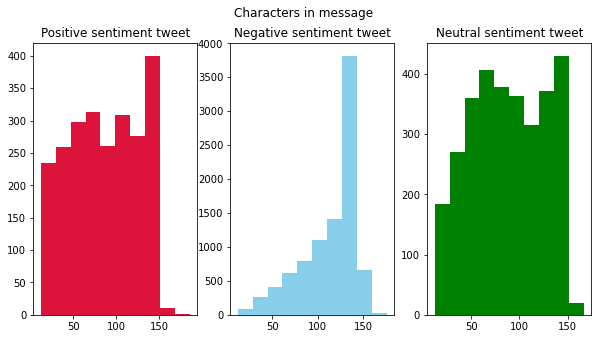

In [58]:
#Number of characters in tweets
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
tweet_len = df_bak[df_bak['airline_sentiment']=='positive']['text'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Positive sentiment tweet')
tweet_len = df_bak[df_bak['airline_sentiment']=='negative']['text'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Negative sentiment tweet')
tweet_len = df_bak[df_bak['airline_sentiment']=='neutral']['text'].str.len()
ax3.hist(tweet_len,color='green')
ax3.set_title('Neutral sentiment tweet')
fig.suptitle('Characters in message')

Text(0.5, 0.98, 'Words in a tweet')

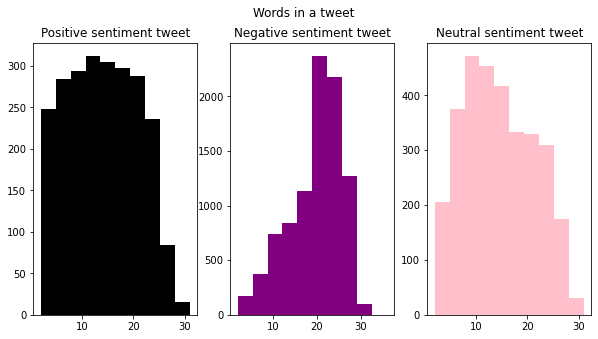

In [60]:
#Number of words in a tweet
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
tweet_len = df_bak[df_bak['airline_sentiment']=='positive']['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='black')
ax1.set_title('Positive sentiment tweet')
tweet_len = df_bak[df_bak['airline_sentiment']=='negative']['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='purple')
ax2.set_title('Negative sentiment tweet')
tweet_len = df_bak[df_bak['airline_sentiment']=='neutral']['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='pink')
ax3.set_title('Neutral sentiment tweet')
fig.suptitle('Words in a tweet')

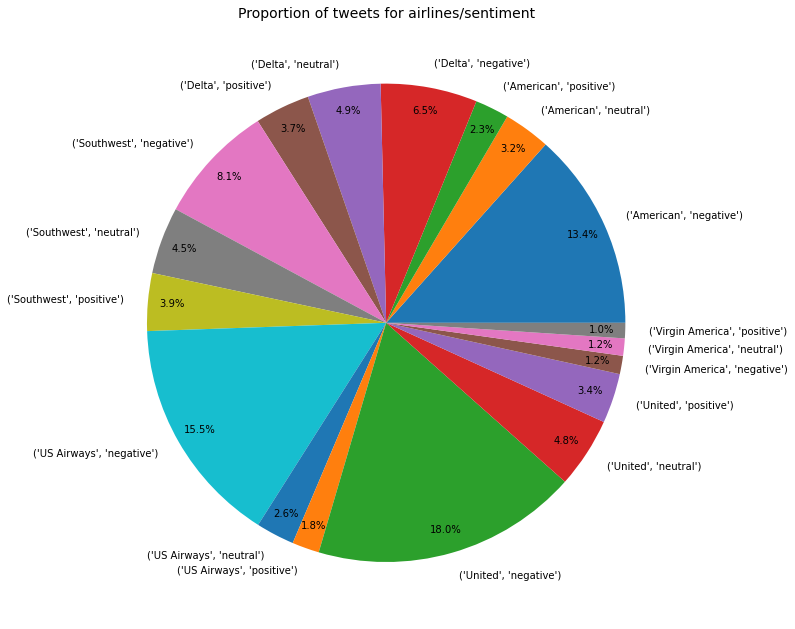

In [147]:
#Proportion of tweets for airlines/sentiment
Category=df_bak.groupby(['airline','airline_sentiment']).size()
pie, ax = plt.subplots(figsize=[20,11])
labels = Category.keys()
plt.pie(x=Category, autopct="%.1f%%",  labels=labels, pctdistance=0.9)
plt.title("Proportion of tweets for airlines/sentiment", fontsize=14);
#pie.savefig("DeliveryPieChart.png")

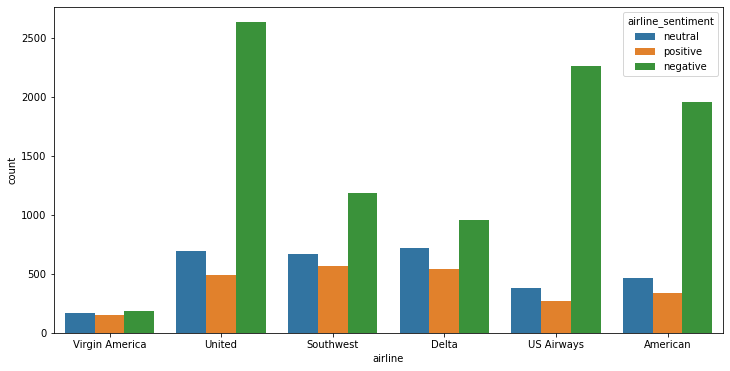

In [84]:
#countplot for each airline for each sentiment
fig, ax = plt.subplots(1,1,figsize=(12,6))

sns.countplot(x='airline', data=df_bak, hue='airline_sentiment')

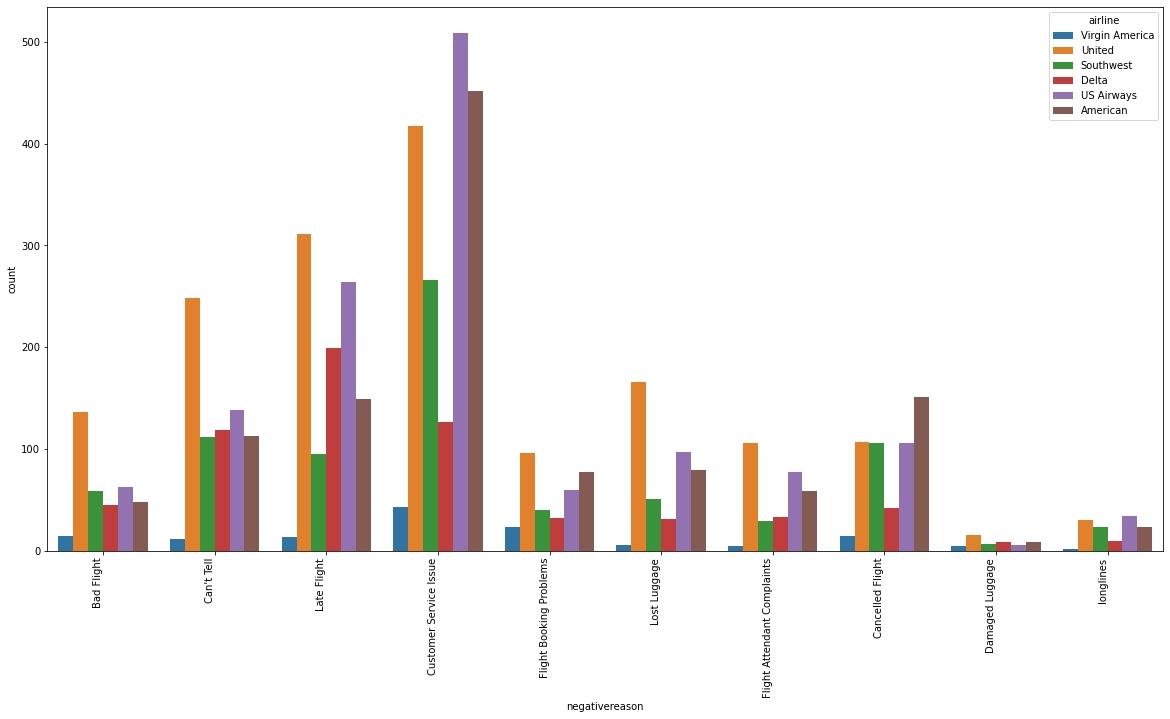

In [151]:
#bar plot for airline/negativereason
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
sns.countplot(x='negativereason', data=df1, hue='airline')

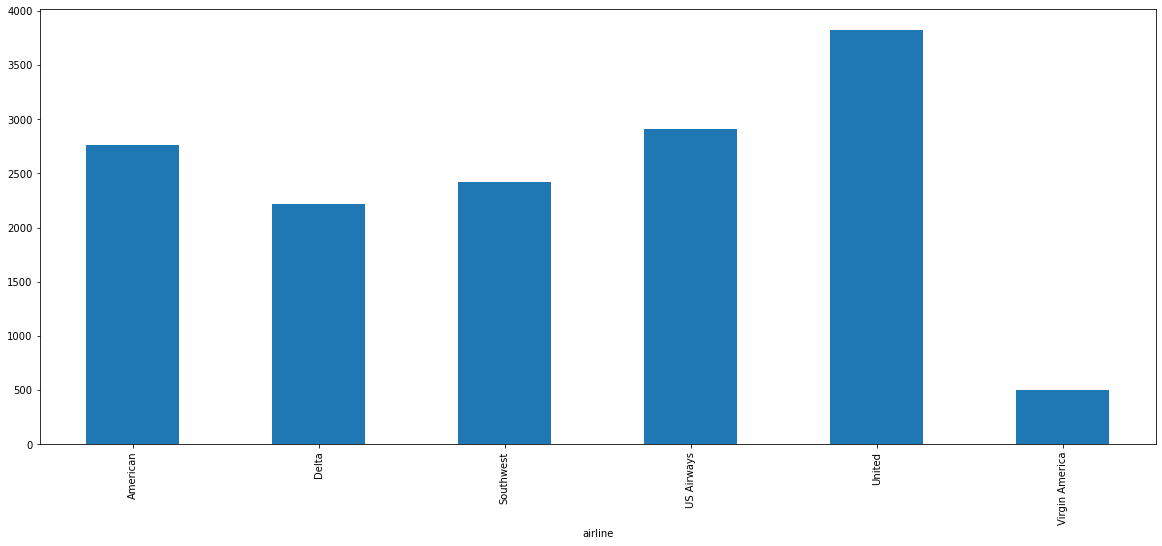

In [95]:
#bar plot airline wise
fig, ax = plt.subplots(1,1,figsize=(20,8))
df_bak.groupby(["airline"]).size().plot.bar()

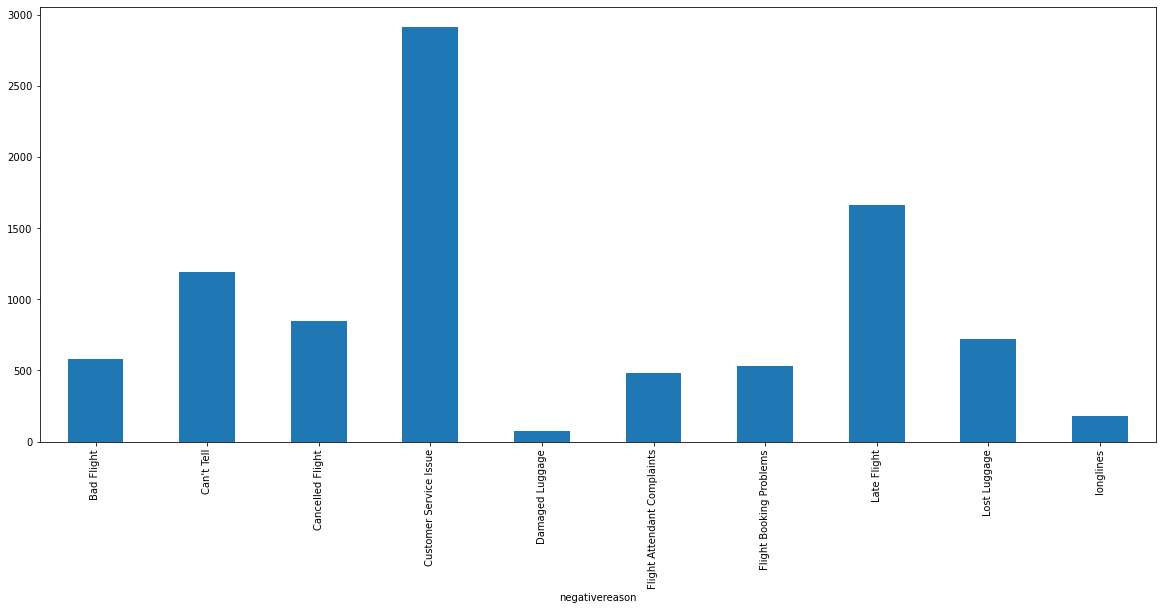

In [96]:
#bar graph negativereason wise
fig, ax = plt.subplots(1,1,figsize=(20,8))
df_bak.groupby(["negativereason"]).size().plot.bar()

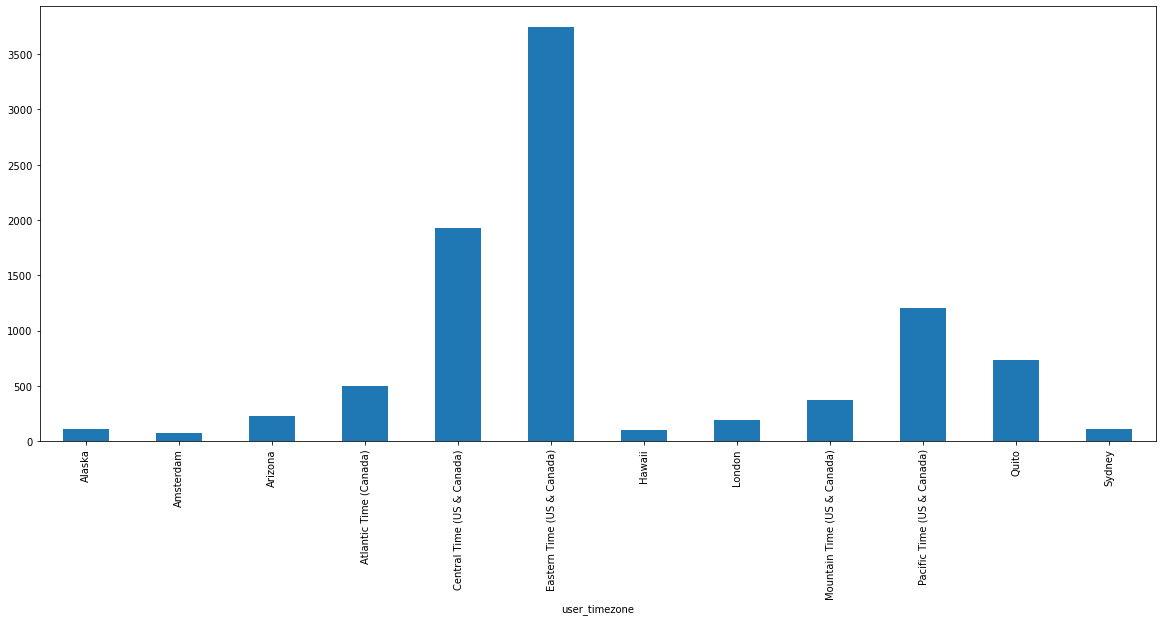

In [139]:
#bar graph user_timezone wise having atleast 50 counts
fig, ax = plt.subplots(1,1,figsize=(20,8))
df_bak[df_bak.groupby('user_timezone')['tweet_id'].transform('count') > 50].groupby('user_timezone')['tweet_id'].count().plot.bar()

In [140]:
df1=df_bak[df_bak.groupby('user_timezone')['tweet_id'].transform('count') > 50]

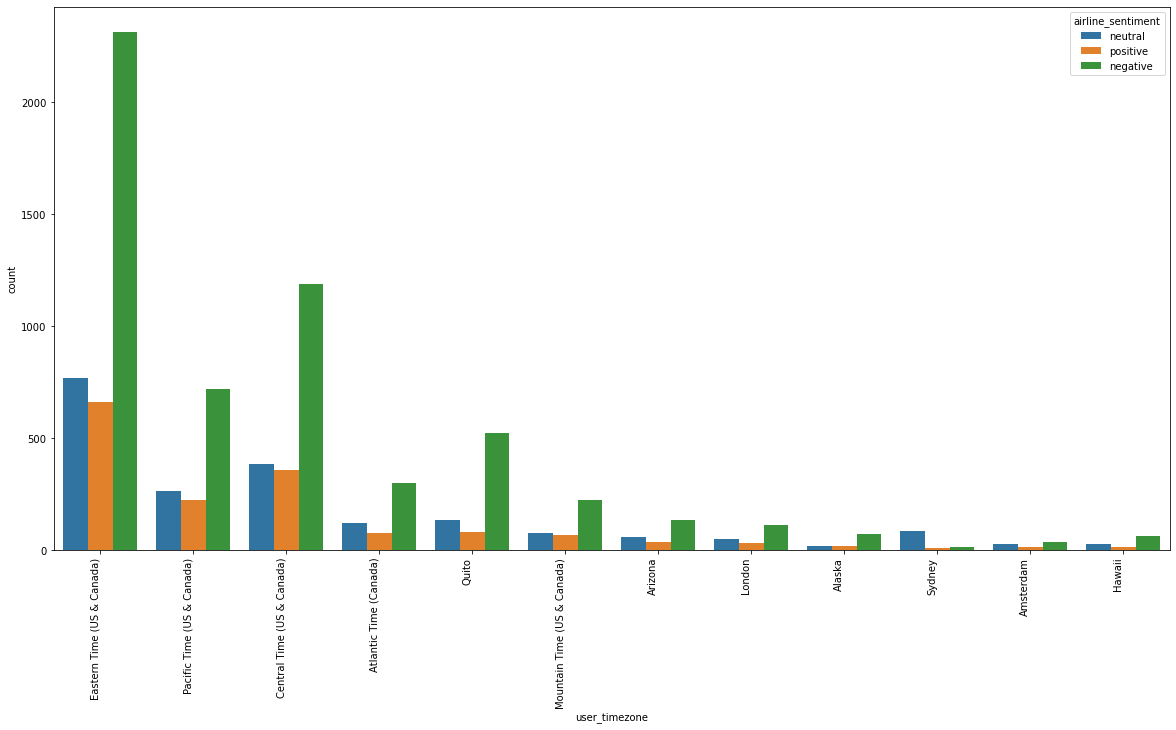

In [145]:
#countplot user_timezone wise for each sentiment
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
sns.countplot(x='user_timezone', data=df1, hue='airline_sentiment')

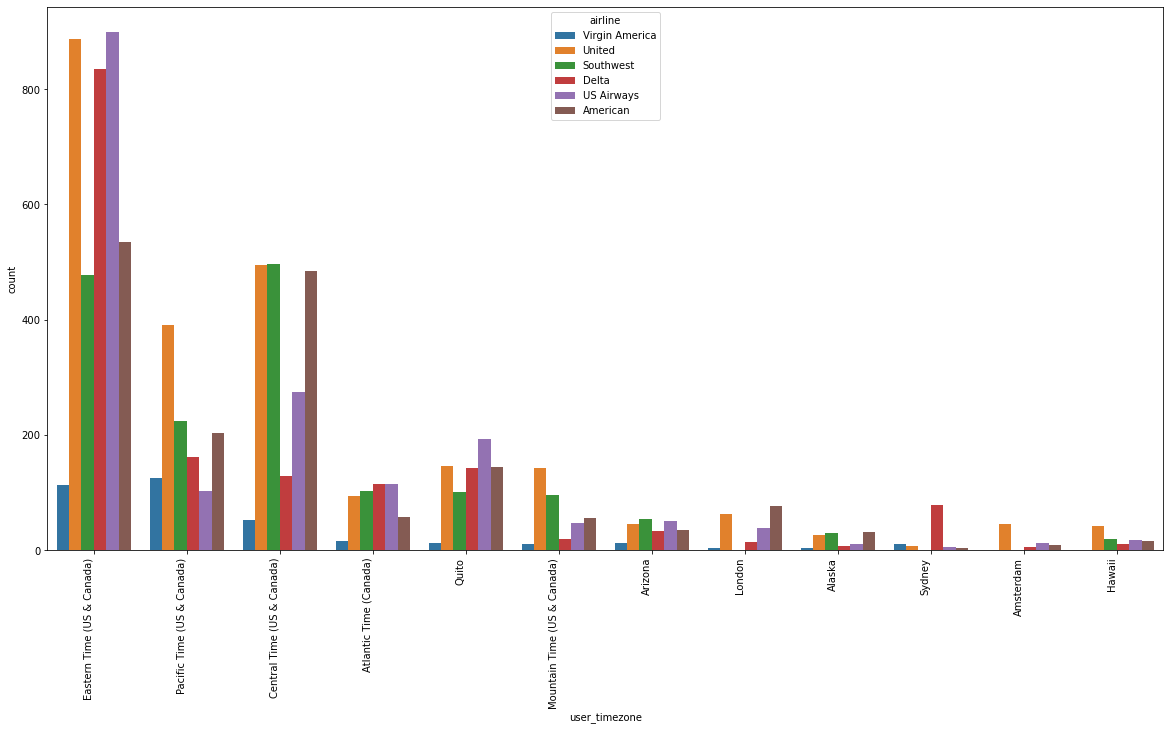

In [146]:
#countplot for user_timezone for each airline
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
sns.countplot(x='user_timezone', data=df1, hue='airline')

---

## Vectorization
### Apply count vectorizer on the required text column to make it suitable for fitting the model

In [21]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(max_features=1000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
data_features = vectorizer.fit_transform(df["clean_text"])

# Numpy arrays are easy to work with, so convert the result to an 
# array
data_features = data_features.toarray()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_features, y, test_size=0.3, random_state=7,stratify=y)

In [24]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
y_train

array([0, 0, 1, ..., 0, 0, 1])

## Modelling and Evaluation
### Fit the model using vectorized column 

In [26]:
%%time
# Initialize a Random Forest classifier with 10 trees
forest = RandomForestClassifier(n_estimators = 10,n_jobs=4) 
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
print ("Training the random forest...")
forest = forest.fit( X_train, y_train)
# random forest performance through cross vaidation 
print (forest)
print (np.mean(cross_val_score(forest,X_train,y_train,cv=10)))

Training the random forest...
RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7333151676829268
Wall time: 13 s


### Evaluate the model using the confusion matrix

In [27]:
# Use the CountVectorizer to make sentiment label predictions
y_pred = forest.predict(X_test)
print (y_pred)

[0 0 1 ... 0 0 0]


In [28]:
#evaluating the model
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.804     0.881     0.840      2753
           1      0.559     0.480     0.516       930
           2      0.667     0.542     0.598       709

    accuracy                          0.741      4392
   macro avg      0.676     0.634     0.651      4392
weighted avg      0.730     0.741     0.733      4392



In [152]:
#confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[2425  230   98]
 [ 390  446   94]
 [ 203  122  384]]


## Modelling and Evaluation
### Fit the model using vectorized column 

In [30]:
#applying XGBoost to the dataset
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train,y_train)

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


### Evaluate the model using the confusion matrix

In [31]:
y_pred_xgb = xgb.predict(X_test)
print (y_pred_xgb)

[0 0 1 ... 0 1 0]


In [32]:
print(metrics.classification_report(y_test, y_pred_xgb, digits=3))

              precision    recall  f1-score   support

           0      0.799     0.909     0.851      2753
           1      0.628     0.460     0.531       930
           2      0.719     0.590     0.648       709

    accuracy                          0.762      4392
   macro avg      0.716     0.653     0.677      4392
weighted avg      0.750     0.762     0.750      4392



In [33]:
print(metrics.confusion_matrix(y_test, y_pred_xgb))

[[2502  165   86]
 [ 425  428   77]
 [ 203   88  418]]


## Vectorization
### Apply Tf-IDF vectorizer, on the required text column to make it suitable for fitting the model

In [34]:
tfidfvectorizer = TfidfVectorizer()
# tokenize and build vocab
tfidfvectorizer.fit(df["clean_text"])

# encode document
vector = tfidfvectorizer.transform(df["clean_text"])
vector = vector.toarray()


In [35]:
X_train, X_test, y_train, y_test = train_test_split(vector, y, test_size=0.3, random_state=7,stratify=y)

## Modelling and Evaluation
### Fit the model using vectorized column 

In [36]:
%%time
# Initialize a Random Forest classifier with 10 trees
tfidforest = RandomForestClassifier(n_estimators = 10,n_jobs=4) 
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
print ("Training the random forest...")
tfidforest = tfidforest.fit( X_train, y_train)
# random forest performance through cross vaidation 
print (forest)
print (np.mean(cross_val_score(tfidforest,X_train,y_train,cv=10)))

Training the random forest...
RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7421942644817073
Wall time: 35.8 s


### Evaluate the model using the confusion matrix

In [37]:
# Use the CountVectorizer to make sentiment label predictions
y_pred_tfid = tfidforest.predict(X_test)
print (y_pred_tfid)

[1 0 1 ... 0 1 0]


In [38]:
print(metrics.classification_report(y_test, y_pred_tfid, digits=3))

              precision    recall  f1-score   support

           0      0.782     0.907     0.840      2753
           1      0.559     0.432     0.488       930
           2      0.703     0.477     0.568       709

    accuracy                          0.737      4392
   macro avg      0.681     0.605     0.632      4392
weighted avg      0.722     0.737     0.721      4392



In [39]:
print(metrics.confusion_matrix(y_test, y_pred_tfid))

[[2497  193   63]
 [ 448  402   80]
 [ 247  124  338]]


## Modelling and Evaluation
### Fit the model using vectorized column 

In [40]:
tfidxgb = XGBClassifier(random_state=1)
tfidxgb.fit(X_train,y_train)

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluate the model using the confusion matrix

In [41]:
y_pred_xgb_tfid = tfidxgb.predict(X_test)
print (y_pred_xgb_tfid)

[0 0 1 ... 0 1 0]


In [42]:
print(metrics.classification_report(y_test, y_pred_xgb_tfid, digits=3))

              precision    recall  f1-score   support

           0      0.776     0.922     0.843      2753
           1      0.631     0.371     0.467       930
           2      0.713     0.578     0.639       709

    accuracy                          0.750      4392
   macro avg      0.707     0.624     0.650      4392
weighted avg      0.735     0.750     0.730      4392



In [43]:
print(metrics.confusion_matrix(y_test, y_pred_xgb_tfid))

[[2538  127   88]
 [ 508  345   77]
 [ 224   75  410]]


## Conclusion
### Summary from the understanding of the application of Various Pre-processing, Vectorization and performance of the model on the dataset.

### Pre-processing

* BeautifulSoup was able to remove all html tags. Though there wasnt any in the data set
* word_tokenize was used to tokenize the tweets into tokens
* isalpha was used to filter out special characters and numerals
* stopwords was used to remove the stop words
* enchant vocabulary was used to identify only valid words from english
* spacy was used for lemmatization as other libraries were not performing well

### EDA
* United has maximum negative reviews followed by US airways and American
* customer service issue is number 1 reason for negative sentiment followed by Late flight and cant tell
* United has maximum number of reviews followed by US airways and American
* Eastern time has most reviews and negative reviews followed by central time and pacific time
* Eastern time passengers mostly travel by US Airways followed by united and delta
* overall we are seeing 
* Central time passengers mostly travel by United and southwest followed by American

### Vectorization and performance of the model
* XGBoost and CountVectorizer gave the highest accuracy of 76.2%
* XGBoost and tfid gave highest recall of 92.2% for class 0
* XGBoost and tfid gave lowest recall of 37.1% for class 1
* Randomforest and CountVectorizer gave highest precision of 80.4% for class 0
* XGBoost and CountVectorizer gave the highest precision of 71.6% for macro avg
* Randomforest and CountVectorizer gave highest precision of 73% for weighted avg
* XGBoost and CountVectorizer gave the highest f1 score of 85.1% for class 0
* XGBoost and CountVectorizer gave the highest f1 score of 67.7% for macro avg
* XGBoost and CountVectorizer gave the highest f1 score of 75% for weighted avg
* overall we are seeing XGBoost and CountVectorizer has given decent performance for most of the parameters
